# EDA

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
path = '../../data/'

In [3]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train = pd.read_csv(path + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv(path + 'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
df = pd.concat([train,test[test['answerCode']>-1]]).reset_index(drop = True)
submission = pd.read_csv(path + 'sample_submission.csv')

> 시간을 초 단위로 변경

In [5]:
# timetuple, mktime 활용
print("timetuple : ",train['Timestamp'].iloc[0].timetuple())
print("mktime : ",time.mktime(train['Timestamp'].iloc[0].timetuple()))

timetuple :  time.struct_time(tm_year=2020, tm_mon=3, tm_mday=24, tm_hour=0, tm_min=17, tm_sec=11, tm_wday=1, tm_yday=84, tm_isdst=-1)
mktime :  1585009031.0


In [4]:
train['Time'] = train['Timestamp'].apply(lambda x: int(time.mktime(x.timetuple())))
test['Time'] = test['Timestamp'].apply(lambda x: int(time.mktime(x.timetuple())))


> 정답률 함수

In [5]:
def percentile(s):
    return np.sum(s) / len(s)

## train, test Head

In [8]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Time,Timediff,Timepassed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1585009031,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1585009034,3,3
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1585009042,8,11
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1585009049,7,18
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1585009056,7,25


In [9]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Time,Timediff,Timepassed
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,1578567391,0,0
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1578567417,26,26
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,1578567511,94,120
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,1578567516,5,125
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,1578567523,7,132


## feature 개수

> train 과 test의 시험지와 문제와 tag는 같다, user는 겹치지 않음

In [42]:
idx = [0,1,2,4]
print("num of rows : ",train.shape[0])
for col in train.columns[idx]:
    print(f"{col}'s nunique : ",train[f"{col}"].nunique())

num of rows :  2266586
userID's nunique :  6698
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [17]:
print("num of rows : ",test.shape[0])
for col in test.columns[idx]:
    print(f"{col}'s nunique : ",test[f"{col}"].nunique())

num of rows :  260114
userID's nunique :  744
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [18]:
for col in train.columns[idx]:
    print(f"{col}'s compare train, test  : ",len(set(train[f"{col}"].unique()) - set(test[f"{col}"].unique())))

userID's compare train, test  :  6698
assessmentItemID's compare train, test  :  0
testId's compare train, test  :  0
KnowledgeTag's compare train, test  :  0


In [19]:
print("train data null : ",train.isnull().sum().sum())
print("test data null : ",test.isnull().sum().sum())

train data null :  0
test data null :  0


## 정답 오답 개수


> train : 정답이 약 2배가량 많음

In [20]:
answer_count = train['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.sum())

answer count :  1483205
answer rate :  0.654378435232548
wrong answer count :  783381
wrong answer rate :  0.34562156476745204


> test : train과 비슷함

In [21]:
answer_count = test['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.iloc[0:2].sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.iloc[0:2].sum())

answer count :  170383
answer rate :  0.6569109765971393
wrong answer count :  88987
wrong answer rate :  0.3430890234028608


## feature 별 분포

### UserID

In [22]:
user_group_train = train.groupby('userID')
user_group_test = test.groupby('userID')

In [26]:
def draw_group(group,col : str) -> None:
    fig,ax = plt.subplots()
    groupby = (set(train.columns) - set(group.count().columns)).pop()

    group[col].count().hist(bins = 20,ax =ax)
    
    ax.set_title(groupby + " | count")
    ax.set_xlabel("by " + groupby)
    ax.set_ylabel("Count")
    ax.set_label("median")

    ax.axvline(group[col].count().median(),label = "Median",color = 'tomato')
    ax.axvline(group[col].count().mean(),label = "Mean",color = 'orange')
    ax.legend(
        title = "Describe"
    )
    plt.show()

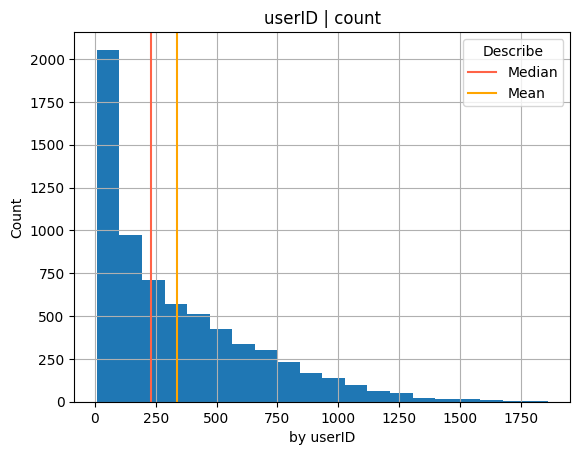

In [24]:
draw_group(user_group_train,"assessmentItemID")

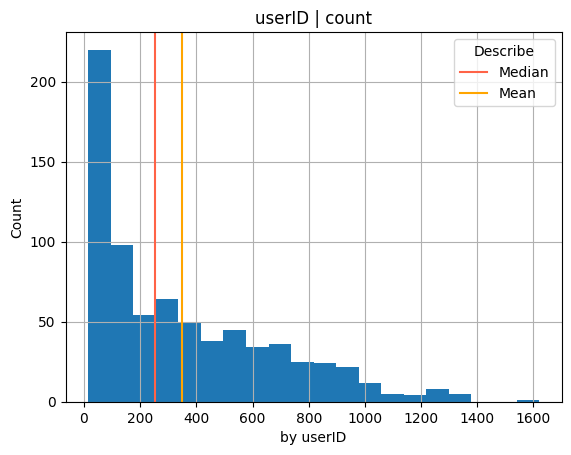

In [25]:
draw_group(user_group_test,"assessmentItemID")

### Timestamp

> 시험지별로 시간이 갱신 된다고 가정

- 해당 문제를 몇 번째 푸는지 column 추가


In [2]:
train = pd.read_csv('./train_time.csv')
test = pd.read_csv('./test_time.csv') # 아래 함수가 오래걸려서 그냥 파일로 저장

In [60]:
# train.to_csv('./train_time.csv',index = False)
# test.to_csv('./test_time.csv',index = False)

- 시험지 내에서 시간차와 흘러간 시간 column 추가

In [20]:
# 옛날거
'''def assess_count(data):
    data['cnt'] = 1
    data['assess_count'] = data.groupby(['userID', 'assessmentItemID'])['cnt'].cumsum()
    return data.drop(columns = 'cnt')
    
def timepass(data : pd.DataFrame):
    timepassed = [0]
    for i in range(1, data.shape[0]) :
        if (data.loc[i-1,'testId'] != data.loc[i,'testId']) | (data.loc[i-1,'userID'] != data.loc[i,'userID'])\
             | (data.loc[i-1,'assess_count'] != data.loc[i,'assess_count']):
            timepassed.append(0)
        else :
            timepassed.append(data.loc[i,'Time'] - data.loc[i-1,'Time'])
    return np.array(timepassed)
timediff = timepass(train)
train['Timediff'] = timediff
timediff = timepass(test)
test['Timediff'] = timediff
train['Timepassed'] = train.groupby(['userID','testId','assess_count'])['Timediff'].cumsum()
test['Timepassed'] = test.groupby(['userID','testId','assess_count'])['Timediff'].cumsum()'''


In [5]:
def assess_count(data):
    data['cnt'] = 1
    data['assess_count'] = data.groupby(['userID', 'assessmentItemID'])['cnt'].cumsum()
    return data.drop(columns = 'cnt')
train = assess_count(train)
test = assess_count(test)

In [6]:
def time_diff(data):
    data['Timediff'] = data.groupby(['userID','testId','assess_count'])['Time'].diff().fillna(0)
    data['Timediff'] = data['Timediff'].apply(lambda x : x if x < 650 else 650)
    data['Timepassed'] = data.groupby(['userID','testId','assess_count'])['Timediff'].cumsum()

### Timediff별 정답률

In [11]:
time_diff(train)
time_diff(test)

In [19]:
time_diff = train.groupby('Timediff').agg({'answerCode':percentile}).reset_index()

<BarContainer object of 100 artists>

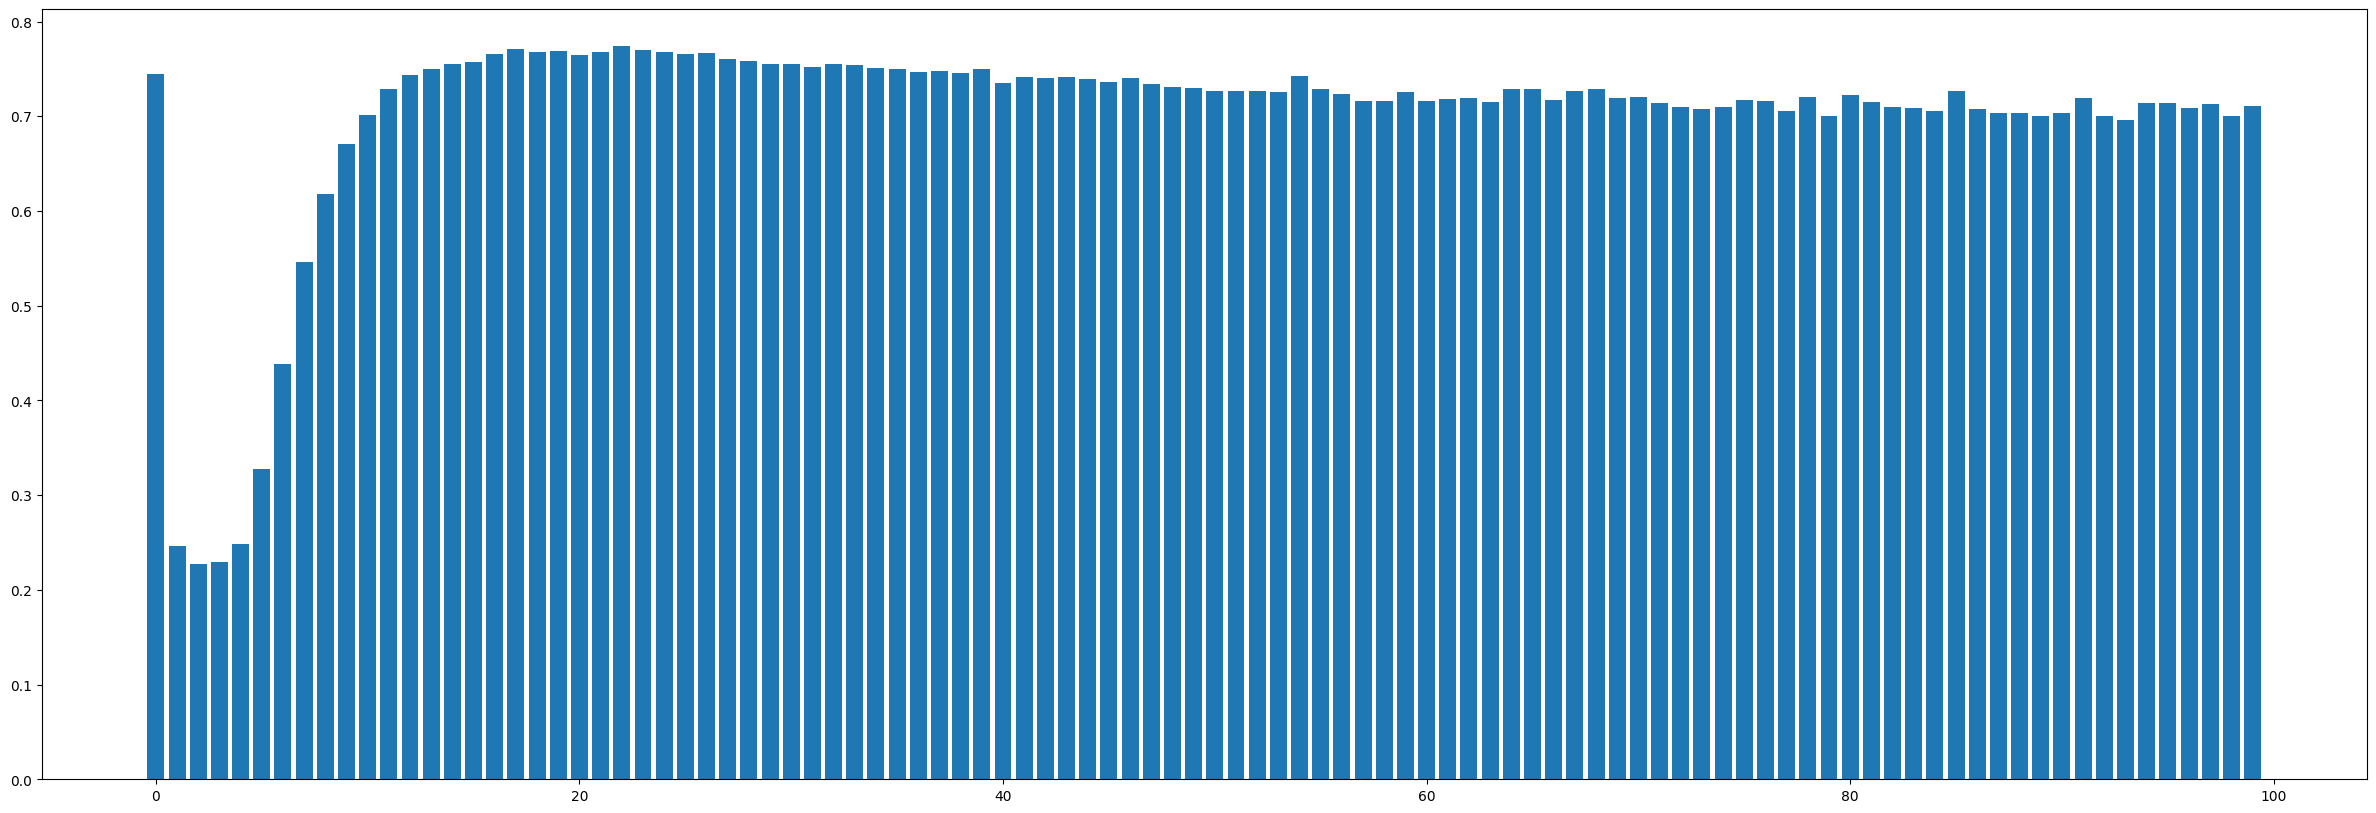

In [20]:
fig,ax = plt.subplots(figsize = (30,10))
plt.bar(time_diff['Timediff'][:100],time_diff['answerCode'][:100])

### assessmentItemID

> 동일 문제를 반복해서 풀 경우 정답률

In [40]:
train.groupby('assess_count').agg({'answerCode':percentile})

,answerCode
assess_count,
1,0.654647
2,0.645138
3,0.438849


> 한 문제당 푼 횟수 분포

In [31]:
assessment_group_train = train.groupby('assessmentItemID')
assessment_group_test = test.groupby('assessmentItemID')

In [32]:
print("문제당 최대 유저 수 : ",assessment_group_train["userID"].count().max())
print("문제당 최소 유저 수 : ",assessment_group_train["userID"].count().min())


문제당 최대 유저 수 :  454
문제당 최소 유저 수 :  43


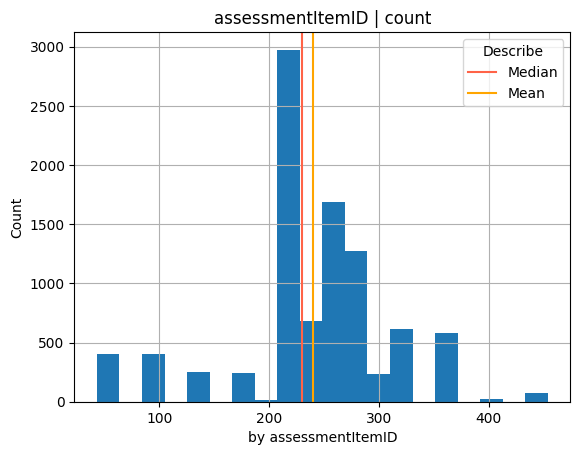

In [33]:
draw_group(assessment_group_train,"userID")

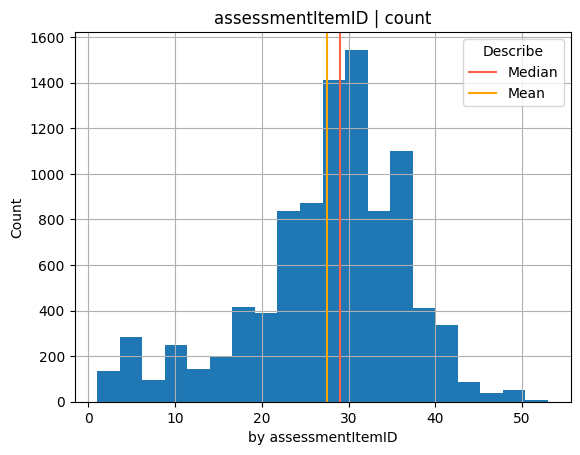

In [34]:
draw_group(assessment_group_test,"userID")

## TestID

> 대분류 나누기

In [72]:
def big_cat(data):
    data['big_cat'] = data['testId'].str[2]
    data_big = data.groupby('big_cat').agg({'answerCode':percentile}).reset_index()
    data_big.columns = ['big_cat','big_cat_rate']
    data = data.merge(data_big,how = 'left',on = 'big_cat')
    return data

In [76]:
train = big_cat(train)
test = big_cat(test)

In [78]:
train.sample(3)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Time,big_cat,big_cat_rate
223172,300,A040162004,A040000162,0,2020-10-26 11:00:05,2119,1603710005,4,0.684056
1875180,3642,A020074004,A020000074,1,2020-07-19 07:12:27,7936,1595142747,2,0.737593
2213688,5974,A050051004,A050000051,1,2020-07-17 06:42:10,3757,1594968130,5,0.658208


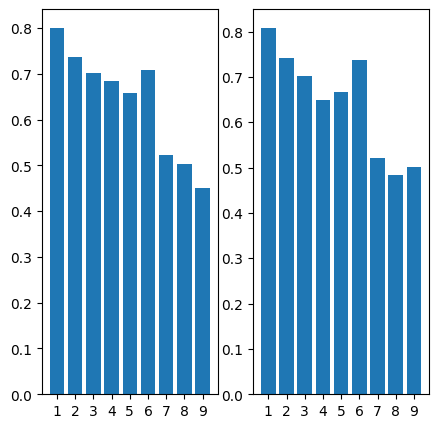

In [46]:
fig,axes = plt.subplots(1,2,figsize = (5,5))
temp = [train_big,test_big]
for i,ax in enumerate(axes):
    ax.bar(np.arange(1,10),temp[i]['answerCode'])
    ax.set_xticks(np.arange(1,10))

In [49]:
test[test['answerCode']==-1].groupby('big_cat')['userID'].count()

big_cat
1     75
2     87
3     85
4     97
5     83
6     66
7    123
8    109
9     19
Name: userID, dtype: int64

## date

In [84]:
df = pd.concat([train,test[test['answerCode']>-1]]).reset_index(drop = True)

In [130]:
def add_date(data):
    data['year'] = data['Timestamp'].apply(lambda x : x.year)
    data['month'] = data['Timestamp'].apply(lambda x : x.month)
    data['day'] = data['Timestamp'].apply(lambda x : x.day)
    date_answer_rate = data.groupby(['year','month','day']).agg({'answerCode':percentile}).reset_index()
    date_answer_rate.columns = ['year','month','day','date_answer_rate']
    data = data.merge(date_answer_rate,how = 'left',on = ['year','month','day'])
    return data

In [132]:
df = add_date(df)

In [136]:
date_group = df.groupby(['day']).agg({'answerCode':percentile,'assessmentItemID':'count'}).reset_index()

In [137]:
date_group

,day,answerCode,assessmentItemID
0,1,0.651347,60794
1,2,0.657436,69511
2,3,0.654962,79255
3,4,0.644669,74038
4,5,0.645326,66774
5,6,0.665483,80537
6,7,0.662667,87845
7,8,0.659323,82612
8,9,0.658183,76111
9,10,0.656896,86210


<BarContainer object of 365 artists>

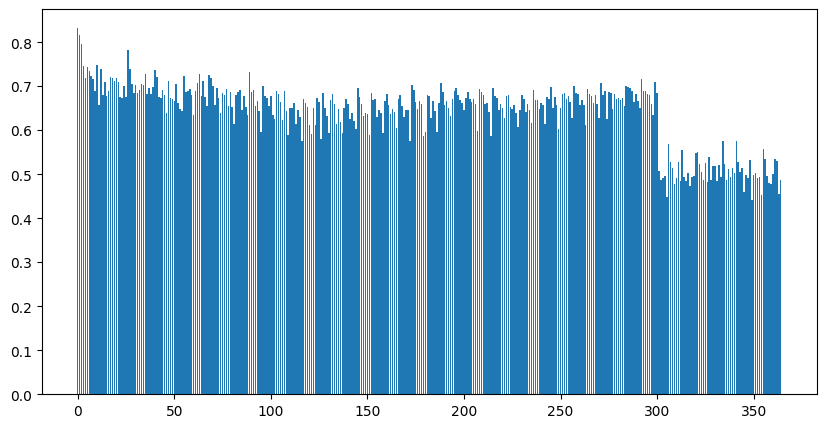

In [114]:
fig,ax = plt.subplots( figsize = (10,5))
index = np.arange(date_group.shape[0])
ax.bar(index, date_group['answerCode'])

<BarContainer object of 31 artists>

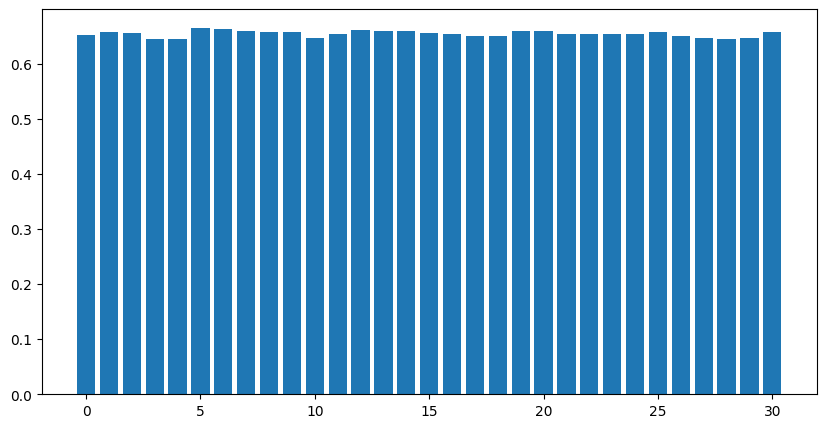

In [138]:
date_groupfig,ax = plt.subplots( figsize = (10,5))
index = np.arange(date_group.shape[0])
ax.bar(index, date_group['answerCode'])

In [116]:
test_group = test[test['answerCode']==-1]

In [122]:
test_group.groupby(['year','month','day']).agg({'answerCode':percentile,'assessmentItemID':'count'}).reset_index()

,year,month,day,answerCode,assessmentItemID
0,2020,7,2,-1.0,1
1,2020,8,3,-1.0,1
2,2020,8,12,-1.0,1
3,2020,8,18,-1.0,1
4,2020,8,19,-1.0,3
...,...,...,...,...,...
100,2020,12,25,-1.0,17
101,2020,12,26,-1.0,2
102,2020,12,27,-1.0,5
103,2020,12,28,-1.0,13


In [124]:
test_group.merge(test_group.groupby(['year','month','day']).agg({'answerCode':percentile,'assessmentItemID':'count'}).reset_index(),how = 'left',on=['year','month','day'])

,userID,assessmentItemID_x,testId,answerCode_x,Timestamp,KnowledgeTag,Time,big_cat,big_cat_rate,year,month,day,answerCode_y,assessmentItemID_y
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,1603718037,5,0.662618,2020,10,26,-1.0,175
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,1609037274,7,0.515691,2020,12,27,-1.0,5
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,1609043709,7,0.515691,2020,12,27,-1.0,5
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,1604036917,9,0.498492,2020,10,30,-1.0,2
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,1603453458,6,0.733989,2020,10,23,-1.0,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,1599530720,4,0.644724,2020,9,8,-1.0,1
740,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,1602582558,3,0.697083,2020,10,13,-1.0,5
741,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,1601779481,5,0.662618,2020,10,4,-1.0,1
742,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,1599397755,5,0.662618,2020,9,6,-1.0,1


In [117]:
add_date(test_group)

/tmp/ipykernel_106212/2331924225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['Timestamp'].apply(lambda x : x.year)
/tmp/ipykernel_106212/2331924225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['Timestamp'].apply(lambda x : x.month)
/tmp/ipykernel_106212/2331924225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

### 이전 문제의 정답 여부가 영향을 줄까나리

In [6]:
df = pd.concat([train,test[test['answerCode']!=-1]])

In [7]:
df['prev_answer'] = df.answerCode.shift(1)
df = df.fillna(0)

In [8]:
df_prev = df.groupby(['userID','prev_answer']).agg({'answerCode':percentile}).reset_index()
df_prev.columns = ['userID','prev_answer','prev_answer_rate']
df_ar = df.groupby('userID').agg({'answerCode':percentile}).reset_index()
df_ar.columns = ['userID','ar']
df = df.merge(df_prev,how = 'left',on = ['userID','prev_answer'])
df = df.merge(df_ar,how = 'left',on = ['userID'])
df['prev_answer_rate'] = df['prev_answer_rate'] - df['ar']
df.drop(columns = 'ar',inplace =True)

<AxesSubplot: >

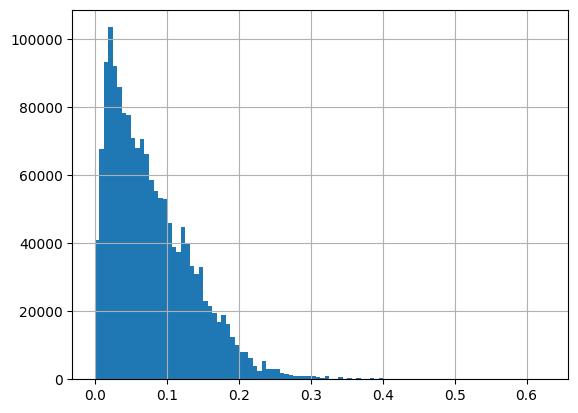

In [31]:
df[df['prev_answer_rate']>0]['prev_answer_rate'].hist(bins = 100)

<AxesSubplot: >

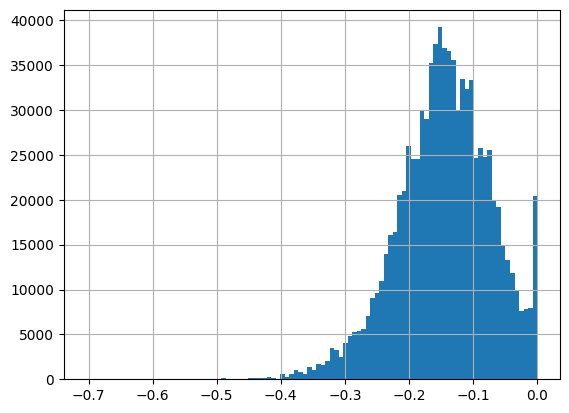

In [30]:
df[df['prev_answer_rate']<0]['prev_answer_rate'].hist(bins = 100)